<a href="https://colab.research.google.com/github/sidchiku9/AI-Project-Customer-Segmentation/blob/main/Targeted_Marketing_by_Customer_Segmentation_using_Artificial_Intelligence_19BCE2232_19BCE2271_19BCE0400.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import plotly.express as px
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go

from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [61]:
sales_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sales_data_sample.csv', encoding = 'unicode_escape')

In [ ]:
sales_df

In [ ]:
sales_df.dtypes

Deleting this sales_df['ORDERDATE'] = pd.to_datetime(sales_df['ORDERDATE'])

In [64]:
sales_df['ADDRESSLINE2'].isnull().sum()

2521

In [ ]:
sales_df.isnull().sum()

In [ ]:
#Personal details : CONTACTFIRSTNAME, CONTACTLASTNAME, PHONE, ADDRESSLINE1, CITY, CUSTOMERNAME, ORDERNUMBER can be dropped
#ADDRESSLINE2, POSTALCODE, STATE and TERRITORY can be dropped as they have a lot of NULL values

df_drop = ['CONTACTFIRSTNAME','CONTACTLASTNAME','PHONE','ADDRESSLINE1','CITY', 'ADDRESSLINE2','POSTALCODE','STATE','TERRITORY', 'CUSTOMERNAME', 'ORDERNUMBER']
sales_df = sales_df.drop(df_drop, axis = 1)
sales_df.head()

In [ ]:
sales_df.isnull().sum()

In [ ]:
sales_df.nunique() #to show the entropy of our data

In [ ]:
sales_df['COUNTRY'].value_counts().index

In [ ]:
sales_df['COUNTRY'].value_counts()

In [71]:
def barplot_visualization(x):
  fig = plt.Figure(figsize = (12, 6))
  fig = px.bar(x = sales_df[x].value_counts().index, y = sales_df[x].value_counts(), color = sales_df[x].value_counts().index, height = 600)
  fig.show()

In [ ]:
barplot_visualization('COUNTRY') 

In [ ]:
barplot_visualization('STATUS')

In [ ]:
sales_df.drop(columns= ['STATUS'], inplace = True)
sales_df

In [75]:
def dummies(x):
  dummy = pd.get_dummies(sales_df[x])
  sales_df.drop(columns = x , inplace = True)
  return pd.concat([sales_df, dummy], axis = 1)

In [ ]:
sales_df = dummies('COUNTRY')
sales_df

In [ ]:
sales_df = dummies('PRODUCTLINE')
sales_df

In [ ]:
sales_df = dummies('DEALSIZE')
sales_df

In [ ]:
y = pd.Categorical(sales_df['PRODUCTCODE'])
y

In [ ]:
y = pd.Categorical(sales_df['PRODUCTCODE']).codes
y

In [81]:
sales_df['PRODUCTCODE'] = pd.Categorical(sales_df['PRODUCTCODE']).codes

In [ ]:
sales_df

In [ ]:
sales_df_group = sales_df.groupby(by = "ORDERDATE").sum()
sales_df_group

In [ ]:
fig = px.line(x = sales_df_group.index, y = sales_df_group.SALES, title = 'Sales')
fig.show()

In [ ]:
sales_df.drop("ORDERDATE", axis = 1, inplace = True)
sales_df.shape

In [ ]:
plt.figure(figsize = (20, 20))
corr_matrix = sales_df.iloc[:, :10].corr()
sns.heatmap(corr_matrix, annot = True, cbar = False)

In [ ]:
sales_df.drop("QTR_ID", axis = 1, inplace = True)
sales_df.shape

Kernel Density Estimation, Historgram and Normal Curve

In [ ]:
import plotly.figure_factory as ff

plt.figure(figsize = (10, 10))

for i in range(8):
  if sales_df.columns[i] != 'ORDERLINENUMBER':
    fig = ff.create_distplot([sales_df[sales_df.columns[i]].apply(lambda x: float(x))], ['distplot'])
    fig.update_layout(title_text = sales_df.columns[i])
    fig.show()

In [ ]:
plt.figure(figsize = (15, 15))

fig = px.scatter_matrix(sales_df,
    dimensions = sales_df.columns[:8], color = 'MONTH_ID')

fig.update_layout(
    title = 'Sales Data',
    width = 1100,
    height = 1100,
)
fig.show()



In [129]:
scaler = StandardScaler()
sales_df_scaled = scaler.fit_transform(sales_df)

In [130]:
sales_df_scaled.shape

(2823, 37)

Elbow method

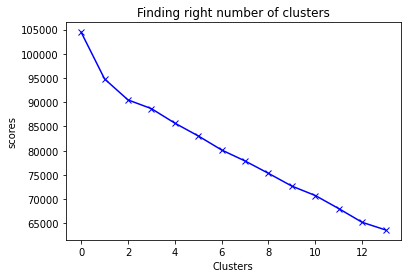

In [131]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(sales_df_scaled)
  scores.append(kmeans.inertia_)

plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

In [132]:
kmeans = KMeans(5)
kmeans.fit(sales_df_scaled)
labels = kmeans.labels_

In [133]:
labels

array([1, 1, 0, ..., 0, 1, 0], dtype=int32)

In [134]:
kmeans.cluster_centers_.shape

(5, 37)

In [ ]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers

In [ ]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers

In [ ]:
sales_df_cluster = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis=1)
sales_df_cluster

Converting ORDERLINENUMBER TO FLOAT

In [138]:
sales_df['ORDERLINENUMBER'] = sales_df['ORDERLINENUMBER'].apply(lambda x : float(x))

In [ ]:
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30,10))
  for j in range(5):
    plt.subplot(1, 5, j+1)
    cluster = sales_df_cluster[sales_df_cluster['cluster'] == j]
    cluster[i].hist()
    plt.title('{} \nCluster : {}'.format(i,j))
  
  plt.show()

The graphs above and the data above is gold and can be utilised to infer data about customers and suitably increase or decrease advertising to them.


In [ ]:
pca = PCA(n_components=3)
principal_comp = pca.fit_transform(sales_df_scaled)
principal_comp

In [ ]:
pca_df = pd.DataFrame(data = principal_comp, columns=['PCA1','PCA2','PCA3'])
pca_df.head()

In [ ]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis=1)
pca_df

In [ ]:
fig = px.scatter_3d(pca_df, x = 'PCA1', y = 'PCA2', z = 'PCA3', color = 'cluster', symbol = 'cluster', size_max = 18, opacity=0.7)
fig.update_layout(margin = dict(l= 0 , r = 0 , b = 0 , t = 0))

Now using two components for a 2D plot

In [ ]:
pca_2d = PCA(n_components=2)
principal_comp_2d = pca_2d.fit_transform(sales_df_scaled)
principal_comp_2d

In [ ]:
pca_df_2d = pd.DataFrame(data = principal_comp_2d, columns=['PCA1','PCA2'])
pca_df_2d.head()

Clarity is more in clusters with K means clustering hence we dwelled more into this

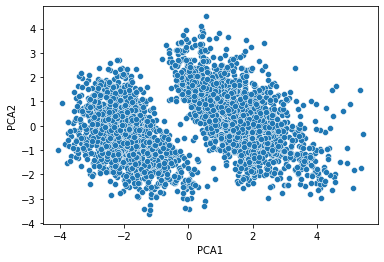

In [147]:
ax = sns.scatterplot(x = 'PCA1', y = 'PCA2', data=pca_df_2d)
plt.show()

In autoencoders then input and the output is the same. We purposefully insert a bottleneck in the middle to keep the data for example an image in a different format that is an encoded format. 

In [ ]:
sales_df.shape

In [ ]:
input_df = Input(shape = (37,))
x = Dense(50, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
encoded = Dense(8, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
decoded = Dense(37, kernel_initializer = 'glorot_uniform')(x)

autoencoder = Model(input_df, decoded)

encoder = Model(input_df, encoded)

autoencoder.compile(optimizer = 'adam', loss='mean_squared_error')

In [ ]:
autoencoder.fit(sales_df, sales_df, batch_size = 128, epochs = 500, verbose = 3)

Notice that the input and the output is the same

In [ ]:
autoencoder.save_weights('autoencoder_1.h5')

In [ ]:
pred = encoder.predict(sales_df_scaled)

In [ ]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(pred)
  scores.append(kmeans.inertia_)

plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

Optimal number of clusters is selected upon the point where exponential drop happens and then point starts to saturate.

In [ ]:
kmeans = KMeans(3)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(sales_df_scaled)

In [ ]:
df_cluster_dr = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.head()

In [ ]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers 

In [ ]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers

In [ ]:
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(3):
    plt.subplot(1, 3, j+1)
    cluster = df_cluster_dr[df_cluster_dr['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))
  
  plt.show()

In [ ]:
pca = PCA(n_components = 3)
prin_comp = pca.fit_transform(sales_df_scaled)
pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2', 'pca3'])
pca_df.head()

In [ ]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

In [ ]:
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3',
              color='cluster', symbol = 'cluster', size_max = 10, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))

**Hierarchical Clustering**

Testing only beyoind this point

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sales_data_sample.csv', encoding = 'unicode_escape')

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [99]:
data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,Shipped,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,Shipped,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,Shipped,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,Shipped,4,10,2003,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [97]:
data.drop("ORDERDATE", axis = 1, inplace = True)

In [ ]:
df_drop = ['CONTACTFIRSTNAME','CONTACTLASTNAME','PHONE','ADDRESSLINE1','CITY', 'ADDRESSLINE2','POSTALCODE','STATE','TERRITORY', 'CUSTOMERNAME', 'ORDERNUMBER']
data = data.drop(df_drop, axis = 1)

In [104]:
df_drop_1 = ['STATUS']
data = data.drop(df_drop_1, axis = 1)

In [106]:
df_drop_2 = ['PRODUCTLINE']
data = data.drop(df_drop_2, axis = 1)

In [108]:
df_drop_3 = ['PRODUCTCODE']
data = data.drop(df_drop_3, axis = 1)

In [111]:
df_drop_4 = ['COUNTRY']
data = data.drop(df_drop_4, axis = 1)

In [113]:
df_drop_5 = ['DEALSIZE']
data = data.drop(df_drop_5, axis = 1)

In [ ]:
from sklearn.preprocessing import normalize
data_scaled = normalize(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)
data_scaled.head()

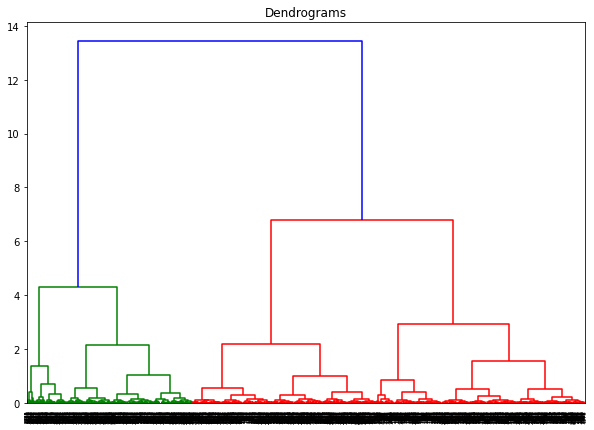

In [115]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

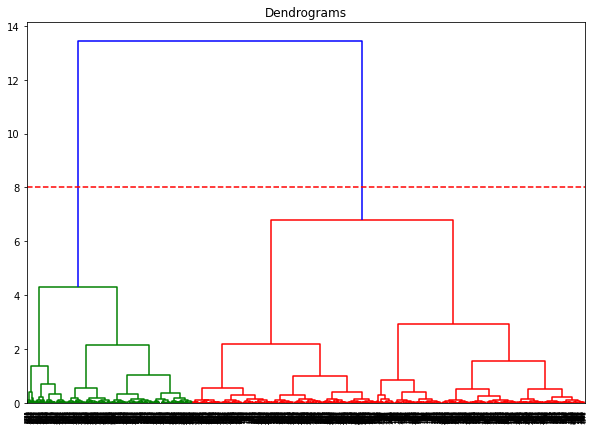

In [116]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.axhline(y=8, color='r', linestyle='--')

In [117]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster.fit_predict(data_scaled)

array([0, 0, 0, ..., 0, 1, 0])

In [119]:
data_scaled.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP
0,0.008563,0.027316,0.000571,0.819492,0.000285,0.000571,0.571732,0.027117
1,0.009949,0.023804,0.001463,0.809343,0.000585,0.001463,0.586107,0.027798
2,0.009377,0.021667,0.000457,0.888331,0.000686,0.001601,0.458077,0.021726
3,0.010587,0.019588,0.001412,0.881446,0.000706,0.001882,0.471224,0.022350
4,0.008782,0.017923,0.002509,0.932961,0.000717,0.001792,0.359006,0.017027


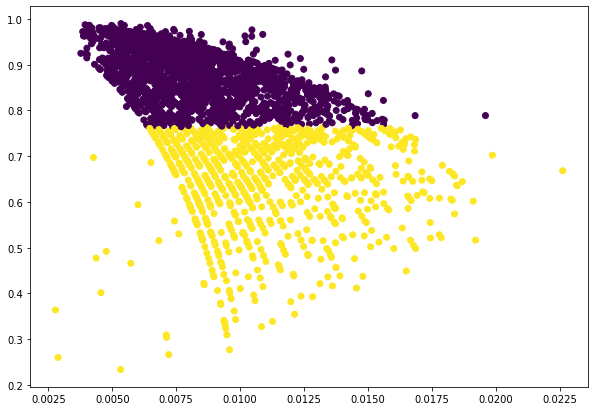

In [126]:
plt.figure(figsize=(10, 7))  
plt.scatter(data_scaled['QUANTITYORDERED'], data_scaled['SALES'], c=cluster.labels_)